In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
from data import stock_data
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Download and load data

In [4]:
con = sqlite3.connect("stock_data.db", check_same_thread=False)

In [5]:
sql = "SELECT * FROM IBM"

In [6]:
df_IBM = pd.read_sql(sql, con, parse_dates="data", index_col="date")

In [7]:
df_IBM

,open,high,low,close,volume
date,,,,,
2024-11-18T00:00:00,207.00,208.4150,205.3701,208.09,3406045.0
2024-11-15T00:00:00,207.46,208.4900,204.0700,204.99,3986460.0
2024-11-14T00:00:00,210.00,210.4999,206.3500,208.99,6372853.0
2024-11-13T00:00:00,209.50,211.4100,209.0701,210.92,3247830.0
2024-11-12T00:00:00,211.90,213.0300,209.0600,210.86,2818216.0
...,...,...,...,...,...
1999-11-05T00:00:00,92.75,92.9400,90.1900,90.25,13737600.0
1999-11-04T00:00:00,94.44,94.4400,90.0000,91.56,16697600.0
1999-11-03T00:00:00,95.87,95.9400,93.5000,94.37,10369100.0


In [8]:
df_IBM.shape

(6303, 5)

In [9]:
df_IBM.index = pd.to_datetime(df_IBM.index, format='ISO8601')

In [10]:
df_IBM.head()

,open,high,low,close,volume
date,,,,,
2024-11-18,207.00,208.4150,205.3701,208.09,3406045.0
2024-11-15,207.46,208.4900,204.0700,204.99,3986460.0
2024-11-14,210.00,210.4999,206.3500,208.99,6372853.0
2024-11-13,209.50,211.4100,209.0701,210.92,3247830.0
2024-11-12,211.90,213.0300,209.0600,210.86,2818216.0


In [11]:
df_IBM.sort_index(inplace=True)

# Calculate Returns

In [12]:
df_IBM['returns'] = np.log(df_IBM['close'] / df_IBM['close'].shift(1))*100

In [13]:
df_IBM["returns"]

date
1999-11-01         NaN
1999-11-02   -2.025544
1999-11-03   -0.465166
1999-11-04   -3.022873
1999-11-05   -1.441090
                ...   
2024-11-12   -1.277024
2024-11-13    0.028451
2024-11-14   -0.919251
2024-11-15   -1.932521
2024-11-18    1.500948
Name: returns, Length: 6303, dtype: float64

# GARCH model

## Train test split

In [14]:
y = df_IBM["returns"].dropna()
cutoff = int(0.8*len(y))

In [15]:
y_train = y.iloc[:cutoff]
#

In [16]:
y_test = y.iloc[cutoff:]
#

# GARCH model walk forward prediction

In [17]:
w_fwd_pred=[]

for i in range(y_test.shape[0]):
    y_train = df_IBM["returns"].iloc[1:-(y_test.shape[0]-i)]
    model = arch_model(y_train, p=1, q=1, rescale=False)
    res= model.fit(disp=0)
    forecasts = res.forecast(horizon=1)
    pred_vol = (forecasts.variance.values[-1,:][0])**0.5
    w_fwd_pred.append(pred_vol)
    

In [18]:
w_fwd_vol = pd.Series(w_fwd_pred, index=y_test.index)

In [19]:
window=21
test_vol = df_IBM["returns"].rolling(window).std().dropna()

In [20]:
test_vol = test_vol.iloc[-y_test.shape[0]:]

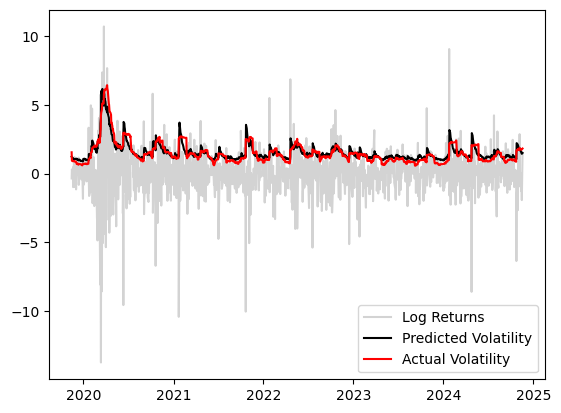

In [21]:
plt.plot(df_IBM["returns"].iloc[-len(y_test):], color="lightgray", label="Log Returns")
plt.plot(w_fwd_vol, color="black", label="Predicted Volatility")
plt.plot(test_vol, color="red", label="Actual Volatility")
plt.legend();

In [22]:
R2 = r2_score(test_vol, w_fwd_vol)
round(R2,2)

0.82

In [23]:
MAE = mean_absolute_error(test_vol, w_fwd_vol)
round(MAE,2)

0.26

In [24]:
MSE = mean_squared_error(test_vol, w_fwd_vol)
round(MSE,2)

0.12

# LSTM model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

## Prepare Input for LSTM (introduce lag)

In [26]:
df=df_IBM
df["rolling_volatility"] = df["returns"].rolling(window=21).std()
df.dropna(inplace=True)
df.head()

,open,high,low,close,volume,returns,rolling_volatility
date,,,,,,,
1999-12-01,102.56,104.44,102.25,103.42,5336400.0,0.348702,2.524261
1999-12-02,103.44,106.31,103.37,105.27,6216900.0,1.773011,2.483744
1999-12-03,109.81,112.87,107.94,111.87,14680300.0,6.080900,2.752959
1999-12-06,113.00,116.50,112.50,116.00,9928300.0,3.625271,2.671188
1999-12-07,117.00,119.19,115.44,116.62,11326100.0,0.533059,2.610349


## Train-test split

In [27]:
cut_off = int(len(df)*0.8)
df_train = df[:cut_off]
df_test = df[cut_off:]

In [28]:
# Function to create LSTM dataset
def create_lstm_dataset(dataset, time_steps=4):
    features = dataset.columns
    
    # Normalize the features
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(dataset[features])
    
    X, y = [], []
    
    # Create sliding window
    for i in range(len(scaled_data) - time_steps):
        # X: Input sequence of time_steps
        X.append(scaled_data[i:i+time_steps])
        
        # y: Next time step's closing price
        y.append(scaled_data[i+time_steps][-1]) 
        
    
    return np.array(X), np.array(y), scaler

In [29]:
# Generate training data
time_steps = 4
X_train, y_train, scaler = create_lstm_dataset(df_train, time_steps=time_steps)

In [30]:
# Get the number of features
data_dim = X_train.shape[2]
data_dim

7

In [31]:
# Build the LSTM model
model = Sequential([
    LSTM(units=100, input_shape=(time_steps, data_dim)),
    Dense(units=1)
])

In [32]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001), loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [33]:
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor validation loss
    patience=10,            # Number of epochs with no improvement
    min_delta=0.001,        # Minimum change to qualify as an improvement
    restore_best_weights=True  # Restore model weights from best epoch
)

In [34]:
# Train the model
history = model.fit(
    X_train, y_train, 
    epochs=100,
    validation_split=0.2,
    batch_size=200, 
    verbose=1,
    shuffle=False,
    callbacks=[early_stopping]
)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0885 - root_mean_squared_error: 0.2877 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0972
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0354 - root_mean_squared_error: 0.1819 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0822
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0127 - root_mean_squared_error: 0.1120 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0592
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0118 - root_mean_squared_error: 0.1062 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0486
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055 - root_mean_squared_error: 0.0724 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0404
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023 - root_mean_squared_error: 0.0475 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0382
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss:

In [35]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

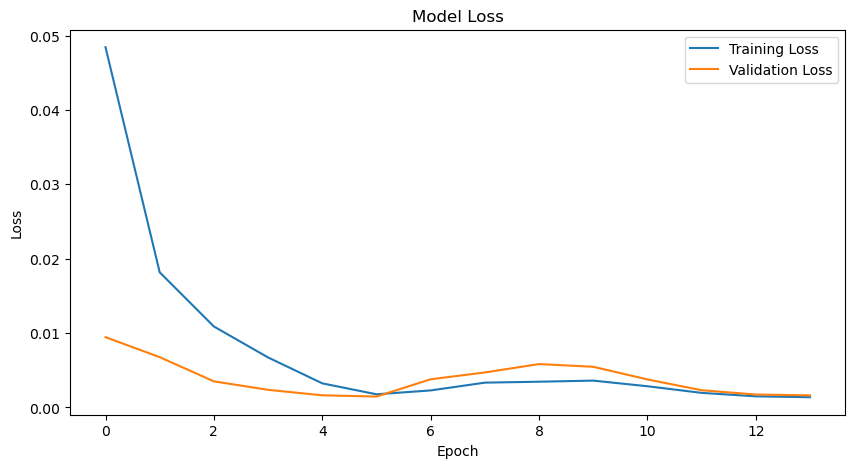

In [36]:
# Optional: Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
# Generate training data
# time_steps = 4
X_test, y_test, scaler = create_lstm_dataset(df_test, time_steps=time_steps)

In [38]:
pred = model.predict(X_test)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [39]:
len(pred)

1253

In [40]:
len(y_test)

1253

In [41]:
mean_squared_error(y_test, pred)

0.002614270650997912

In [42]:
r2_score(y_test, pred)

0.8656847844920708